# Outlier detection

## Choose and generate dataset

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

from matplotlib.colors import Normalize

from sklearn import datasets, metrics, preprocessing, svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
#A changer selon l'ordinateur
pathtodata='./Data_OK/'

In [3]:
datasetsnames=["generated","creditcard","http","kdd10","kdd","smtp"]

#Changer le numéro pour choisir le nom
datasetname=datasetsnames[1]

- N.B. : creditcard ne fonctionne pas pour LocalOutlierFactor
- kdd est trop gros (fonctionne pour 40% pour 16 GB RAM), utiliser seulement kdd10
- smtp ne présente que 3 outliers, inintéressant

In [4]:
def column_generator(nbvar):
    SAcolumns=[]
    for i in range(1,nbvar+1):
        SAcolumns.append("var_{}".format(i))
    SAcolumns.append("label")
    return SAcolumns

def data_set(dataname):
    if dataname=="generated":
        return pd.read_csv(pathtodata+'Data_2.csv', low_memory=False)
    elif dataname=="creditcard":
        return pd.read_csv(pathtodata+'creditcard_2.csv', low_memory=False)
    elif dataname=="smtp" or dataname=="http" or dataname=="SA" or dataname=="SF":
        dataset=datasets.fetch_kddcup99(subset=dataname, data_home=None, shuffle=False, random_state=None, percent10=True, download_if_missing=True)
        data=dataset['data']
        target=dataset['target']
        data=np.append(data,np.array(target).reshape(-1,1),axis=1)
        if dataname=="smtp" or dataname=="http":
            return pd.DataFrame(data=data,columns=column_generator(3))
        elif dataname=="SF":
            return pd.DataFrame(data=data,columns=column_generator(4))
        elif dataname=="SA":
            return pd.DataFrame(data=data,columns=column_generator(41))
    elif dataname=="kdd10":
        return pd.read_csv(pathtodata+'kddcup.data_10_percent_corrected.csv', header=None, low_memory=False)
    elif dataname=="kdd":
        return pd.read_csv(pathtodata+'kddcup.data.corrected.csv', header=None, low_memory=False)

In [5]:
data=data_set(datasetname)

## Making our data one-class

1) Convert the outliers into class 1 (normal) and class -1 (outlier) <br>
2) Copy outlier labels to evaluate performance later <br>
3) Compute proportion of outliers <br>
4) Drop label and useless columns from the dataframe, to do unsupervised training with unlabelled data

In [6]:
all_label_columns = {"generated": 'label',
                      "creditcard": 'label',
                      "kdd10": 41,
                      "kdd": 41,
                      "smtp": 'label', 
                      "http": 'label',
                      "SA": 'label',
                      "SF": 'label'}
all_normal_labels = {"generated": "b'0'",
                       "creditcard": 0,
                       "kdd10": "normal.",
                       "kdd": "normal.", 
                       "smtp": b'normal.', 
                       "http": b'normal.', 
                       "SA": b'normal.', 
                       "SF": b'normal.'}

label_column = all_label_columns[datasetname]
normal_label = all_normal_labels[datasetname]

normal_value = -1
outlier_value = 1

data.loc[data[label_column] != normal_label, "outlier"] = outlier_value
data.loc[data[label_column] == normal_label, "outlier"] = normal_value
if datasetname=="kdd10" or datasetname=="kdd":
    data.loc[data[label_column] == "smurf.", "outlier"] = normal_value 
    data.loc[data[label_column] == "neptune.", "outlier"] = normal_value 

target = data['outlier']

outliers = target[target == outlier_value]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

all_useless_columns = {"generated": ["label", "outlier"],
                     "creditcard": ["Time", "label", "outlier"],
                     "kdd10": [41, 1, 2, 3, "outlier"],
                     "kdd": [41, 1, 2, 3, "outlier"],  
                     "smtp": ["label", "outlier"], 
                     "http": ["label", "outlier"], 
                     "SA": ["label", "var_2", "var_3", "var_4", "outlier"], 
                     "SF": ["label", "var_2", "outlier"]
                    }

useless_columns = all_useless_columns[datasetname]
data.drop(useless_columns, axis=1, inplace=True)

print(data.shape) 

outliers.shape (492,)
outlier fraction 0.001727485630620034
(284807, 29)


## Proportion of outliers

In [7]:
nu = outliers.shape[0] / target.shape[0]  
print("nu = ", nu)

nu =  0.001727485630620034


## Normalize data

In [8]:
def normalized_data(data, type_normalization):
    if type_normalization=="normalizer":
        return normalize(data,axis=0)
    elif type_normalization=="minmaxscaler":
        min_max_scaler = preprocessing.MinMaxScaler()
        return min_max_scaler.fit_transform(data)
    elif type_normalization=="standardscaler":
        standard_scaler = preprocessing.StandardScaler()
        return standard_scaler.fit_transform(data)
    elif type_normalization==False:
        return data

In [9]:
normalization_types = ["normalizer","minmaxscaler","standardscaler",False]

#Choisir la normalisation minmaxscaler pour Autoencoder
chosen_normalization = normalization_types[2] 

In [10]:
data = normalized_data(data, chosen_normalization)

## Shuffling and splitting data into training and test sets

In [11]:
def data_split(data,target,ratio):
    if 0<ratio and ratio<1:
        X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle = True, train_size = ratio)
    elif ratio==1:
        X_train, X_test, y_train, y_test = data, data, target, target
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = data_split(data, target, 1)

In [13]:
X_train.shape

(284807, 29)

## Profit function

In [14]:
def profit(y_true,y_pred,verbose=True):
    true_positive = np.sum(np.where(np.logical_and(y_true==1,y_pred==1),1,0))
    false_positive = np.sum(np.where(np.logical_and(y_true==-1,y_pred==1),1,0))
    positive = np.sum(np.where(y_true==1,1,0))
    negative = len(y_true)-positive
    if verbose:
        print("True Positive Rate: ", true_positive/positive)
        print("Number of False Positive: ", false_positive)
        print("False Positive Rate: ", false_positive/negative)
        print()
    return 160*(2*true_positive/positive-1) - 160*false_positive/negative

## Grid Search tests

### Grid Search 1

In [15]:
accuracy_scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, pos_label = outlier_value)
auc_scorer = make_scorer(roc_auc_score)
recall_scorer = make_scorer(recall_score, pos_label = outlier_value)

In [16]:
Gamma_range = [10**(i) for i in range(-5,6)]
G_range=list(np.linspace(1e-5,1e-3,5))

tuned_parameters = [{'gamma': G_range}]

In [17]:
def Grid_Search(X_train, y_train, X_test, y_test, tuned_parameters, scorer, grid_scores=False):
    clf = GridSearchCV(svm.OneClassSVM(nu=nu), tuned_parameters, cv=3, scoring=scorer, verbose=3)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set :", clf.best_params_) 
    
    if grid_scores:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
    
    print()
    return clf.best_params_

In [18]:
best_params = Grid_Search(X_train, y_train, X_test, y_test, tuned_parameters, recall_scorer)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=1e-05 .....................................................
[CV] ............ gamma=1e-05, score=0.6774193548387096, total=  23.8s
[CV] gamma=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s remaining:    0.0s


[CV] ............ gamma=1e-05, score=0.7058823529411765, total=  23.9s
[CV] gamma=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] ........................... gamma=1e-05, score=1.0, total=  23.4s
[CV] gamma=0.0002575 .................................................
[CV] ........ gamma=0.0002575, score=0.6774193548387096, total=  23.5s
[CV] gamma=0.0002575 .................................................
[CV] ........ gamma=0.0002575, score=0.7058823529411765, total=  23.9s
[CV] gamma=0.0002575 .................................................
[CV] ....................... gamma=0.0002575, score=1.0, total=  23.9s
[CV] gamma=0.000505 ..................................................
[CV] ......... gamma=0.000505, score=0.6728110599078341, total=  24.4s
[CV] gamma=0.000505 ..................................................
[CV] ......... gamma=0.000505, score=0.7058823529411765, total=  24.3s
[CV] gamma=0.000505 ..................................................
[CV] ........................ gamma=0.000505, score=1.0, total=  23.6s
[CV] gamma=0.0007525 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.6min finished


Best parameters set found on development set : {'gamma': 1e-05}



In [19]:
best_params

{'gamma': 1e-05}

### Grid Search 2 : graphs of best values

In [20]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
data = np.asarray(data)
target = np.asarray(target)

In [21]:
def find_best_contamination(classifier, contaminations):
    score_max = -np.inf
    cont_opti = 0
    mean_score_train = []
    mean_score_test = []
    for c in contaminations:
        print("Contamination = ", c)
        clf = classifier(contamination=c, random_state=42)
        score_train = 0
        score_test = 0
        for train_index, test_index in skf.split(data, target):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index], target[test_index]
            clf.fit(X_train)
            y_pred_train = -clf.predict(X_train)
            y_pred_test = -clf.predict(X_test)
            print("Test")
            score_test += profit(y_test,y_pred_test)
            print("Train")
            score_train += profit(y_train,y_pred_train)
            print()
        print()
        print()
        print()
        score_test /= 5 
        score_train /= 5
        mean_score_train.append(score_train)
        mean_score_test.append(score_test)
        if score_test > score_max:
            score_max = score_test
            cont_opti = c
    print(cont_opti)
    print(score_max)
    plt.plot(contaminations,mean_score_train,label="Score en apprentissage")        
    plt.plot(contaminations,mean_score_test,label="Score en test")
    plt.show()

### Isolation Forest

Contamination =  0.05
Test
True Positive Rate:  0.8686868686868687
Number of False Positive:  2641
False Positive Rate:  0.04644496421222939

Train
True Positive Rate:  0.8447837150127226
Number of False Positive:  11061
False Positive Rate:  0.048630040623955824


Test
True Positive Rate:  0.8181818181818182
Number of False Positive:  2768
False Positive Rate:  0.04867840247612683

Train
True Positive Rate:  0.8498727735368957
Number of False Positive:  11059
False Positive Rate:  0.04862124755992473


Test
True Positive Rate:  0.8163265306122449
Number of False Positive:  2753
False Positive Rate:  0.04841461055519406

Train
True Positive Rate:  0.8629441624365483
Number of False Positive:  11053
False Positive Rate:  0.04859486836783145


Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  2823
False Positive Rate:  0.04964563951954698

Train
True Positive Rate:  0.850253807106599
Number of False Positive:  11058
False Positive Rate:  0.048616851027909185


Test


Test
True Positive Rate:  0.9081632653061225
Number of False Positive:  6193
False Positive Rate:  0.10891089108910891

Train
True Positive Rate:  0.9010152284263959
Number of False Positive:  24708
False Positive Rate:  0.10862951304011396


Test
True Positive Rate:  0.9285714285714286
Number of False Positive:  6114
False Positive Rate:  0.10752158697219633

Train
True Positive Rate:  0.8908629441624365
Number of False Positive:  24712
False Positive Rate:  0.10864709916817614





Contamination =  0.12000000000000001
Test
True Positive Rate:  0.8888888888888888
Number of False Positive:  6742
False Positive Rate:  0.11856567539524823

Train
True Positive Rate:  0.9007633587786259
Number of False Positive:  26988
False Positive Rate:  0.11865360603555915


Test
True Positive Rate:  0.9393939393939394
Number of False Positive:  6718
False Positive Rate:  0.1181436083217558

Train
True Positive Rate:  0.8905852417302799
Number of False Positive:  26992
False Positive Rate:  0.118671192

Test
True Positive Rate:  0.9191919191919192
Number of False Positive:  9994
False Positive Rate:  0.17575576385347239

Train
True Positive Rate:  0.9185750636132316
Number of False Positive:  40651
False Positive Rate:  0.178723422963966


Test
True Positive Rate:  0.9285714285714286
Number of False Positive:  10245
False Positive Rate:  0.1801698819970807

Train
True Positive Rate:  0.9187817258883249
Number of False Positive:  40651
False Positive Rate:  0.178723422963966


Test
True Positive Rate:  0.8979591836734694
Number of False Positive:  10045
False Positive Rate:  0.17665265638464378

Train
True Positive Rate:  0.9213197969543148
Number of False Positive:  40652
False Positive Rate:  0.17872781949598157


Test
True Positive Rate:  0.9285714285714286
Number of False Positive:  10254
False Positive Rate:  0.18032815714964037

Train
True Positive Rate:  0.9238578680203046
Number of False Positive:  40649
False Positive Rate:  0.17871462989993492





Contamination =  0.19
Test


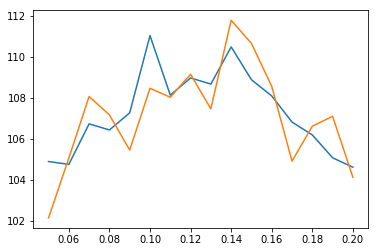

In [22]:
classifier = IsolationForest
contaminations = np.linspace(0.05,0.20,16)
find_best_contamination(classifier, contaminations)

### Elliptic Envelope

Contamination =  0.05


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-284.795917336731407 > -285.246053036994454)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.661808511163144 > -252.609947661745650)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-168.145401154922553 > -269.537179709362817)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-287.179430259437595 > -288.832728927521771)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-345.545903

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.694231255986438 > -303.973637711870197)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.390324380477807 > -306.188560956656033)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-345.545903649791285 > -349.989167935395756)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-344.802975534265101 > -347.101962221980614)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.977085

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-320.201678839571457 > -342.972280849337722)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-229.452288002133002 > -277.302214491427492)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-345.983956598980683 > -351.670398155434725)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-252.800350534209883 > -255.597381948452380)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.747772

Test
True Positive Rate:  0.7171717171717171
Number of False Positive:  2772
False Positive Rate:  0.04874874698837557

Train
True Positive Rate:  0.727735368956743
Number of False Positive:  11107
False Positive Rate:  0.04883228109667095




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.657119942536497 > -280.826327002962103)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.772675290849747 > -280.856450011641073)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-194.212196924472863 > -304.893905348469787)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.928293657248986 > -271.540000507881700)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-264.396748

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.795090199925681 > -272.320412741134419)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.966234577187038 > -271.948358599029802)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.776527659530217 > -249.811400271266677)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.922576582424199 > -249.467714106972494)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.843329

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.931101994608184 > -249.835274510670530)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.262152556724345 > -280.787122788254010)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.950720596729582 > -279.997586486115267)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.129313517110347 > -271.216291824798475)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-253.664683

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.821499269361425 > -284.603538702153514)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.060516579892237 > -269.103578675930805)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.648543981357562 > -242.801407410293223)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.747989672015194 > -191.078831482385738)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-281.051603

Test
True Positive Rate:  0.8686868686868687
Number of False Positive:  2759
False Positive Rate:  0.04852012732356717

Train
True Positive Rate:  0.8142493638676844
Number of False Positive:  11073
False Positive Rate:  0.048682799008142374




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-142.724350086821289 > -143.162230934603542)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.603019081941000 > -248.780985614885481)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.615673666489243 > -196.626910416225655)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.846667961808549 > -240.158471398751260)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-171.233525

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-128.835296699305644 > -293.599320314865679)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-160.693854251255061 > -161.277891746730006)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-149.343236248109122 > -291.455391193496439)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.846003598773194 > -210.804125647329101)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.679613

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.129492692864829 > -240.664569323701528)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.907550210640068 > -235.002853330986056)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.009056143823727 > -261.553985705281207)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.676056890345251 > -178.100789733968668)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.248819

Test
True Positive Rate:  0.3469387755102041
Number of False Positive:  2698
False Positive Rate:  0.047447373511773916

Train
True Positive Rate:  0.35786802030456855
Number of False Positive:  11252
False Positive Rate:  0.049469778238925136




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.480766572029495 > -192.941267496513063)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.806227996476593 > -266.157106074608407)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.611979997863727 > -234.457651817011282)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-161.310864058334317 > -161.741333441423222)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.113860

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.338736173179569 > -247.151283781534914)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.611979997863727 > -240.604492155395917)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-164.237746066626329 > -168.520876358791043)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.198036313196951 > -272.652632301272888)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.002931

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.726896060719469 > -274.183444150489777)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.268557751542318 > -268.771526884308855)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-162.560634219683777 > -163.716595613627362)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.679315931289949 > -254.483554247705626)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-131.123085

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-163.534689487447451 > -163.632463569085445)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.146967918917738 > -271.705688727279608)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.973983636381803 > -182.937005185750678)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.8367346938775511
Number of False Positive:  2703
False Positive Rate:  0.04753530415208484

Train
True Positive Rate:  0.8147208121827412
Number of False Positive:  11072
False Positive Rate:  0.04867840247612683




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.873360737220878 > -148.362183342564890)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.501298120730439 > -186.885878872062875)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.909506476852755 > -247.833193824048180)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.610150073805528 > -253.514712617594967)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-269.824488

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-230.538728632604887 > -285.773949498435854)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.294942678332006 > -250.882464443197591)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.972023096763195 > -253.302834900283443)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.960159264429876 > -276.605283304966122)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.429842

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.868221055535486 > -245.602021810353591)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.024054612124417 > -252.938617029513637)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.253162994361190 > -187.662346303746290)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.543458412907512 > -307.569656191822503)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.103973

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.773532466841800 > -278.075482175598495)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-282.107667717212166 > -282.243737770547909)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-141.087625667301040 > -252.961562550698574)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.32653061224489793
Number of False Positive:  2787
False Positive Rate:  0.04901253890930834

Train
True Positive Rate:  0.3629441624365482
Number of False Positive:  11250
False Positive Rate:  0.04946098517489404





Contamination =  0.055


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-281.200020351295677 > -281.933366847313664)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-346.246873851343025 > -347.665902452094883)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.686983892330829 > -276.657522347305189)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-294.812742780471694 > -310.088733261617961)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.852088

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.999904770283649 > -279.565900491321088)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.481200437540906 > -278.199471788979963)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.663867688944919 > -247.814720692498327)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-194.924744655091501 > -267.526496471929420)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-282.073922

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-253.255429012696908 > -253.513869699636501)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-227.908660959352915 > -300.883534823867592)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.966373757548666 > -243.412956053553103)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-252.877952673251059 > -255.318050057782727)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-252.665476

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.896056581248445 > -245.220475202752965)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-265.811497225156018 > -343.122636892145749)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.048965231967060 > -183.066187041892874)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.011914970450164 > -248.439454138635000)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.759123

Test
True Positive Rate:  0.8282828282828283
Number of False Positive:  3132
False Positive Rate:  0.055079753090762004

Train
True Positive Rate:  0.7709923664122137
Number of False Positive:  12229
False Positive Rate:  0.05376519001811371




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.242022458979960 > -272.752412232434267)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.942603302152605 > -247.958759810329752)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.262879270665138 > -243.561860621777640)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.143896771696234 > -254.319975879018727)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.846345

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.714871878607852 > -271.941556990779532)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.371217182772625 > -249.411270444625700)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-135.368532063976119 > -302.640952814891932)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.089353779731653 > -281.316670037199856)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.553703

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.788904535731973 > -246.296682028046860)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-145.458006358637249 > -301.359745514434167)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.975583944621178 > -256.785680669694727)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.767453306937057 > -298.800155784117010)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-205.462675

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.217057644402132 > -263.747222212914437)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.942603302152605 > -249.948534703682697)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.904025095051452 > -253.978979697771678)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-251.346462771742580 > -252.888096794689204)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.255521

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.067851288450299 > -270.210588466823026)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-155.152353453023267 > -298.107849265138157)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-118.503290593501703 > -290.167038735578103)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-217.995628738204914 > -254.240441273508623)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.7777777777777778
Number of False Positive:  3036
False Positive Rate:  0.05339148479679229

Train
True Positive Rate:  0.8142493638676844
Number of False Positive:  12212
False Positive Rate:  0.053690448973849426




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.200185128997106 > -273.475768471075355)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.375841739939375 > -271.749180981088955)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.902261413891239 > -271.133119580824768)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.243400681705936 > -272.040318617914579)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.332233

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-163.339114563658313 > -297.638938231834800)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-125.840969253360072 > -297.237283683656244)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.079267646530752 > -274.157960651668418)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.619738293698987 > -272.539119370076435)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.733668

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.721347761262905 > -271.691508895617858)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.097985763992483 > -279.612052319108614)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-153.207318819083355 > -295.348451346818308)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.489844362596273 > -279.455664424206589)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.315874

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-281.226534458579408 > -283.206591990454569)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.599485430132745 > -188.167474595063169)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.632836117680910 > -270.626081351381799)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.255888545124890 > -277.494842947307006)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.591973

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.218667394772893 > -186.369622589524170)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.303421161185355 > -271.632385924273763)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.623073644616284 > -274.344199828582475)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-159.205115342973158 > -263.278780904939254)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-128.071403

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.120907368076587 > -272.059813780615343)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.910514343560180 > -248.759912349776698)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.608337702567781 > -272.389898786223682)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.083184963810197 > -275.569500076079123)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.663913

Test
True Positive Rate:  0.8367346938775511
Number of False Positive:  3029
False Positive Rate:  0.053268381900357

Train
True Positive Rate:  0.8223350253807107
Number of False Positive:  12208
False Positive Rate:  0.05367286284578724




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-228.996425740935933 > -253.736038447707756)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-283.842300218173250 > -284.757696206412618)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.433039267119000 > -243.838804249850256)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.837169095205866 > -328.851871158644883)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.318310

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.111517055467516 > -332.354541055139975)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-201.671465010883082 > -300.148658590675495)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-284.141233922539129 > -284.489209597060210)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.556155744498909 > -305.137890209771911)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-193.769351

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-269.113318236367377 > -272.580327984598512)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.037020479920869 > -245.479478220350018)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.576435769162231 > -273.250478171397162)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.867140771863177 > -268.743520862540890)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-175.439288

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.224184808575956 > -280.085606310585774)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.188876235226502 > -244.555005732965753)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.309964531121722 > -302.183301507163037)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.928068445957877 > -245.150022003582166)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.242216

Test
True Positive Rate:  0.8877551020408163
Number of False Positive:  3046
False Positive Rate:  0.05356734607741413

Train
True Positive Rate:  0.8147208121827412
Number of False Positive:  12211
False Positive Rate:  0.05368605244183388




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.275302201489268 > -266.879106963941467)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-156.374465529790172 > -239.650686617648290)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.073444204243060 > -248.967513842474403)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.805066987301757 > -264.566667170270080)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.846959

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.556037912004172 > -270.950447149301283)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-175.637966730770927 > -268.790746663858329)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.950420185895268 > -245.326868551277869)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.029777759414628 > -239.385454345700907)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.404600

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.507779109379499 > -240.194165791834223)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.340509800244718 > -240.194943248958054)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.124099295117730 > -237.342755903198395)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.768126075159699 > -240.195829652643681)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.073444

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.975655402457363 > -244.911247034628360)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-268.974785824285561 > -269.764259796981264)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.134262749210421 > -239.013139219587686)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-156.729820277453229 > -294.034844377307991)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.887401

Test
True Positive Rate:  0.7551020408163265
Number of False Positive:  3032
False Positive Rate:  0.05332114028454355

Train
True Positive Rate:  0.8477157360406091
Number of False Positive:  12198
False Positive Rate:  0.05362889752563178





Contamination =  0.060000000000000005


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-168.553904481048477 > -298.891980108410110)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.569976927730949 > -245.110923421568771)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.247059738850453 > -274.460603006468659)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.071995641268387 > -247.446053015724175)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.197880

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.048427026983063 > -216.921587045196446)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-127.264914728779004 > -251.929441538427739)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.508640854544979 > -216.776899592058186)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.005397818960802 > -187.436351377968606)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-173.615767

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.441054183789561 > -248.701996399084862)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.962323175500188 > -271.413034706372116)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.235204268333604 > -249.635751666086549)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-219.659196989330241 > -220.150260616739729)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.364217

Test
True Positive Rate:  0.8484848484848485
Number of False Positive:  3227
False Positive Rate:  0.05675043525666954

Train
True Positive Rate:  0.8295165394402035
Number of False Positive:  13345
False Positive Rate:  0.0586717197474632




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.497533510626255 > -241.180288794520209)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-266.952822034633186 > -268.216763215690719)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.694737027013389 > -210.156622283507545)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.690871398469085 > -274.776935132932238)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-216.028063

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-268.919190202754976 > -275.473514437781091)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.920944139391963 > -242.089408491863566)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.081896016618032 > -238.452917774328739)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.040273021935150 > -239.482893053855236)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.526642

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.522668405122545 > -250.837185740126756)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.929866046036693 > -280.292574778806170)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.616949298516431 > -235.409200308692363)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.795476840111633 > -242.273055793575850)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.729249

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.330008720938451 > -239.671207191851295)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.425463716629906 > -243.268151988772388)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-185.650465966531442 > -185.740590424136769)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.515029192688871 > -272.995244871034174)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.711239

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.324380687896337 > -275.037257860865566)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.635592310640817 > -241.045505374271897)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.050942165599082 > -241.406449205641962)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.226591578170485 > -187.335289583715053)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.977718

Test
True Positive Rate:  0.7676767676767676
Number of False Positive:  3298
False Positive Rate:  0.05799905034908464

Train
True Positive Rate:  0.8371501272264631
Number of False Positive:  13342
False Positive Rate:  0.05865853015141656




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.700687285274796 > -267.539407756565481)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.517131767454259 > -241.613761193761576)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.245731031455335 > -243.998430526171632)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.968572458869488 > -249.979068067843855)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-128.363314

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.697088937849372 > -244.445358363107545)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.968812212840959 > -244.950220978089533)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.217581711783652 > -218.937730203864049)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.519752556341643 > -244.198729300053742)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.760662

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.834296197125184 > -186.587239224440054)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.709543746084876 > -188.867018923419351)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.003394574549816 > -242.185104134108798)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.544979991363817 > -243.256085026450933)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.040923

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.858305091496504 > -243.508171864183453)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.074762608956235 > -216.382424630657738)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-264.544389185789782 > -267.110429524194501)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.288430598695442 > -242.631339157433388)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.926036

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.919261905358866 > -243.092204381082638)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-267.386183389785685 > -273.883090557366359)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.071866962179797 > -264.801181834525039)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  3378
False Positive Rate:  0.0594059405940594

Train
True Positive Rate:  0.8299492385786802
Number of False Positive:  13344
False Positive Rate:  0.05866732321544765




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.569049690684210 > -270.879327860599687)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.576017116616327 > -238.601258867666985)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.434470673022474 > -234.676716648484387)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-228.152794554117406 > -271.040750693737323)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.803424

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.157137667542202 > -245.119339861436799)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.446326318860031 > -271.501065570502021)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.639409023883672 > -269.118455897838828)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-230.086989442462880 > -256.783792244000495)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-123.421312

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.988084288550084 > -240.766989726260704)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-229.724030054554390 > -255.062524722476610)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.735398283082986 > -239.206864073104413)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-152.220081659457293 > -300.283636597724410)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.312963

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.070664883799566 > -268.094145721274060)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.257031191370658 > -272.233428542584647)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.359209925937876 > -276.473014810733105)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-151.768625773206082 > -301.047601988272731)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.785981

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.015544395230847 > -267.924104780756750)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.430493814723462 > -268.027915302368683)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-149.447988041992431 > -299.889649290869443)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-165.618719905482578 > -166.048912360557296)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.903583

Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  3377
False Positive Rate:  0.059388354465997224

Train
True Positive Rate:  0.8350253807106599
Number of False Positive:  13342
False Positive Rate:  0.05865853015141656




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.495593287220913 > -276.322344416387864)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.538384990891984 > -278.872666847139669)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.962846754974692 > -275.104480474172647)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.959938553665438 > -273.082648889371740)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.084666

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.062680162069967 > -275.015777129174467)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.708531196656111 > -273.764022196381234)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.309506045708531 > -278.170141571581439)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-290.355866307104066 > -290.388722652628530)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.918018

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.365419940034087 > -275.840082096779952)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-289.645518081566820 > -289.739874692600097)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-138.860314770367495 > -300.694533055799980)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.493393504286587 > -296.927258791809720)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.089626

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-264.996465091342998 > -309.021400998741797)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.927518732757420 > -274.600034739449484)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.723576418974631 > -272.692475515572653)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-289.452687428629133 > -289.699592529790493)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.747186

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-319.396897268053863 > -342.238745674198185)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-322.246594259693097 > -340.121636952808558)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-322.381222696326859 > -350.103423908650257)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.005523819131440 > -274.825758331270151)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-230.975999

Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  3409
False Positive Rate:  0.05995111056398713

Train
True Positive Rate:  0.8223350253807107
Number of False Positive:  13347
False Positive Rate:  0.05868051281149429





Contamination =  0.065


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.833916319259629 > -276.179220569825304)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.646402996509096 > -240.721167250930137)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.677415118914183 > -242.680831650200076)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-205.127326470388681 > -236.297960504354535)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.416187

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.397579598047173 > -207.087330640776514)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-185.516150052024557 > -187.137180423656901)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-173.099772638668526 > -299.837803056115149)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.001347033570994 > -272.377257555403901)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-162.519705

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.502913792031904 > -271.617675732720954)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-204.571170027605007 > -262.490473844856240)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-167.900519141328942 > -263.010053083780463)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-204.707807122094380 > -235.678502424267606)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-160.311332

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-178.802416644739509 > -179.165328591073717)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-119.083776246011041 > -262.753925461193376)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.470625739696914 > -241.800337078454078)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.643537919476046 > -275.767605713134458)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.899756

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.963538142749542 > -277.604367846904211)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.884912397507264 > -238.874850137512595)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.548626133516535 > -242.485336451969545)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.416368047108136 > -237.682967897439539)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.8383838383838383
Number of False Positive:  3658
False Positive Rate:  0.06433005645147108

Train
True Positive Rate:  0.8396946564885496
Number of False Positive:  14480
False Positive Rate:  0.06366178358510807




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.171010425329570 > -182.400490426021491)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-266.088391817731747 > -310.036247151038651)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-126.298513300517854 > -294.904597503398463)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.237579229133047 > -234.553683342092000)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-310.731048

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.896600768750687 > -245.674826307725994)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.568834321426493 > -275.020561792100921)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.790295077125592 > -245.329065863888673)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.731530602446838 > -248.542333775174541)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.719691

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-287.564722445309769 > -305.916790716738660)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.906150471891692 > -245.927397763829418)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.575622629986441 > -252.043182854879376)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-268.980965953938266 > -270.153632818275184)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.004651

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.236876709499853 > -247.869233339204698)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.926730818506741 > -242.712685449140650)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.087739240122886 > -271.005244086147400)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.983303886421538 > -244.400110273447751)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.321830

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.048054772161066 > -247.369784348147050)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.707266451730987 > -265.547940630811866)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.032359806076954 > -313.156252880380237)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.769342027481002 > -267.916303629572383)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.020162

Test
True Positive Rate:  0.8080808080808081
Number of False Positive:  3596
False Positive Rate:  0.06323971651161564

Train
True Positive Rate:  0.8498727735368957
Number of False Positive:  14476
False Positive Rate:  0.06364419745704589




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-159.217714455275456 > -159.678260989123345)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.432693280580111 > -278.456370546476137)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.159180741801549 > -277.447409594516444)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-153.084593754148898 > -295.133204829452552)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-216.317152

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.378532861099586 > -278.389368152275040)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-217.000209700280891 > -241.446552949698628)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.144755201674343 > -244.813762564872377)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-220.747846364895253 > -244.596517990301834)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-217.815366

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.458096125928023 > -278.813298586235874)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.640254685893979 > -279.343518141115965)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.378532861099586 > -278.075210980230679)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.518759825030003 > -272.732690627829697)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-216.386021

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.859182619850685 > -241.514090440183679)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.154108124111019 > -280.685470818614533)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-220.017502229243291 > -245.091036256259230)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-163.686523195699124 > -297.711012132609198)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.078092

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-221.209751565851718 > -267.388756875022239)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.075515935844862 > -245.839028189869282)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-221.875781650708433 > -246.813011142776929)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.494061162237898 > -250.762393811154425)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.196438

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.213925955677723 > -279.929617684373682)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.442863280109805 > -276.067086531928169)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.992155963928781 > -278.108271718183858)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-220.517114474419884 > -246.822841802584691)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.792730

Test
True Positive Rate:  0.8571428571428571
Number of False Positive:  3704
False Positive Rate:  0.06513901834233157

Train
True Positive Rate:  0.8350253807106599
Number of False Positive:  14481
False Positive Rate:  0.06366618011712362




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.667130268922193 > -176.855989075207162)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-268.851443948031147 > -272.259152243657809)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.450815336163657 > -275.546274633910514)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.306601439168276 > -309.674589158633012)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.492192

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.184130368053388 > -278.482153025761022)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.995116165143827 > -244.368123929588108)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.558269206251595 > -245.009218088000097)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.600756192770518 > -184.990059890252695)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.314252

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.856643280641833 > -277.283816730539115)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.075926939896249 > -276.319753492371376)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.920992843851536 > -216.266903155406226)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.152701795228580 > -242.441799923956324)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-185.329079

Test
True Positive Rate:  0.40816326530612246
Number of False Positive:  3585
False Positive Rate:  0.06304626910293161

Train
True Positive Rate:  0.39593908629441626
Number of False Positive:  14654
False Positive Rate:  0.0644267801558131




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.116118231019357 > -239.761905708253380)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.888459245176932 > -245.355180824953351)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.651027881554569 > -212.420659890842956)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.850693291990325 > -212.955718582313608)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.531268

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.277949967975445 > -274.001256998066651)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.266985588952139 > -185.392449328749137)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.036545788774248 > -271.659016509902528)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.339588887226171 > -272.330141368391480)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.021113

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.920095265791645 > -207.426248705421557)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-191.583531132800090 > -192.326044586907557)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.274282521079328 > -270.542032187332211)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.140722605355933 > -272.886411580317372)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-211.624466

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-158.923767349697329 > -159.876095020991897)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.161691238859419 > -239.733394458762348)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.820331263355257 > -267.917561780906567)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.629874356335961 > -273.232746791852378)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.756127

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.445293119857013 > -240.115743840525965)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.711191605121996 > -261.350845687188666)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.956448295495647 > -264.323097547451653)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.218406543341757 > -270.104533645082711)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.389883

Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  3585
False Positive Rate:  0.06304626910293161

Train
True Positive Rate:  0.8375634517766497
Number of False Positive:  14480
False Positive Rate:  0.06366178358510807





Contamination =  0.07


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.720323981381796 > -148.374788692039544)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.724237141188041 > -279.019792962847248)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.966466480425851 > -183.905588661881183)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.265725956755318 > -274.642580724362119)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.858840

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-195.149701758447122 > -256.865467271845318)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.693555580605732 > -278.060386569678599)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.696278253152514 > -278.606845002840998)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.105158128659184 > -278.173600512859707)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.850163

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.016080130710748 > -269.587977589083778)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.855293397094329 > -242.696641642850324)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.010290965578974 > -241.360316969320650)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.648992040243400 > -276.439024585627237)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.691102

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.997832606274670 > -215.330729805943008)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.587968404955234 > -220.500454170504497)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-144.567275683843604 > -303.806361384951174)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-185.437608436488887 > -267.777585305365619)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-192.187511

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.888948820460087 > -269.255967286640271)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.270341304834744 > -267.775439261291865)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.488067882310133 > -276.585966278327192)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.678298026676146 > -279.379570949651622)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.888948

Test
True Positive Rate:  0.42424242424242425
Number of False Positive:  3956
False Positive Rate:  0.06957072261400207

Train
True Positive Rate:  0.4071246819338422
Number of False Positive:  15790
False Positive Rate:  0.06942124052547351




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-124.834298066209016 > -125.383878219512269)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-153.639416922083768 > -261.533533233035200)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-197.013708733831095 > -267.981649241126661)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.559702136290980 > -243.718564830505045)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.262020

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-171.068177374476392 > -172.098692674753352)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.306677139383396 > -273.244392847101892)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.764979159837367 > -274.820486353152717)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-149.244240729130524 > -150.646126580350369)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.166180

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.236769396996920 > -276.691833972483550)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-188.686869057228932 > -189.574654944788563)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.650275055074019 > -239.467692960396391)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.265371707076667 > -240.289652220993815)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-178.897497

Test
True Positive Rate:  0.8282828282828283
Number of False Positive:  3893
False Positive Rate:  0.06846279654608445

Train
True Positive Rate:  0.8498727735368957
Number of False Positive:  15616
False Positive Rate:  0.06865624395476848




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.877097456368006 > -246.010882989617272)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-191.531372708649485 > -268.295199949418532)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.479643768280710 > -277.646247746845916)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-160.081146026314343 > -274.061670210955981)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.571380

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-192.579356943737679 > -269.282628330481373)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.374299379422723 > -280.245301582550042)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.095970554124079 > -248.851532440424961)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.348494574085151 > -264.007013493945124)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-140.745611

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.010163375989663 > -244.305089552826843)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.592302832564457 > -247.960574791386932)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-160.880961268750752 > -273.106624818234820)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-133.753520765948451 > -323.810299786715518)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.096860

Test
True Positive Rate:  0.8571428571428571
Number of False Positive:  3885
False Positive Rate:  0.06832210752158697

Train
True Positive Rate:  0.8401015228426396
Number of False Positive:  15619
False Positive Rate:  0.06866943355081512




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.074390491785948 > -246.316460252611506)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-107.527572161406667 > -295.332744651802557)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-291.879700123791281 > -313.959901279413828)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.611005130181724 > -249.284381934913199)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.111985

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-108.755690026397815 > -297.080884757537717)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-154.863753948596752 > -333.093594801410063)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.809113493044919 > -248.987014425217097)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.640085237976109 > -254.723944183636775)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-160.022514

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-282.477694414661073 > -282.531126079142666)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.808939189296609 > -272.108225171405934)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.373003055859385 > -285.798842285644071)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-107.934155663885363 > -300.076931188850949)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.870600

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-250.807340883847189 > -253.767741259040292)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.059831568754674 > -266.412789405795309)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-266.316213920479242 > -271.255474140820581)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-134.585137251443086 > -257.284390441547316)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-265.665586

Test
True Positive Rate:  0.8673469387755102
Number of False Positive:  3912
False Positive Rate:  0.06879693297926595

Train
True Positive Rate:  0.8401015228426396
Number of False Positive:  15619
False Positive Rate:  0.06866943355081512




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-169.280967229619819 > -327.306498791941408)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.862664662790678 > -239.318526360093387)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-178.456780926396050 > -304.716723708111999)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-254.377235095612775 > -255.803947879938590)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.104667

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-201.819695164055418 > -269.202228208739200)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.148497258965847 > -245.607622007492267)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-222.948517725548498 > -258.267245130955473)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.911783924361202 > -278.066856581906109)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.363059

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.947765887580090 > -273.371287723224839)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.508807971325723 > -243.434927625920665)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.820636285206547 > -183.988972715936882)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.163286524477940 > -184.723766516058760)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.754573

Test
True Positive Rate:  0.8061224489795918
Number of False Positive:  4016
False Positive Rate:  0.07062589029773315

Train
True Positive Rate:  0.850253807106599
Number of False Positive:  15615
False Positive Rate:  0.06865184742275293





Contamination =  0.07500000000000001


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-146.761941567801131 > -300.426111829643787)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-235.438762352546007 > -236.649168381662065)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-231.332056407149452 > -271.802059404907084)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.820448932546583 > -269.914876719374433)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-201.870169

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-199.033340377371132 > -297.467445015217038)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.983527484250999 > -238.317721321101800)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.491159777162352 > -278.629453423363543)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.148023020570918 > -273.601065603553423)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-132.187089

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-251.490841020825087 > -251.620665472440521)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-127.928884813392443 > -295.330514189181713)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-131.575392606907997 > -267.625139679033680)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.643835374551827 > -244.032168469371754)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-231.285921

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-251.654434508821623 > -252.529405543320195)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.759711435686228 > -272.755934227495857)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.897741382049446 > -274.600030279906150)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.177808232528434 > -280.303905337897163)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-130.428909

Test
True Positive Rate:  0.8484848484848485
Number of False Positive:  4144
False Positive Rate:  0.07287691468969278

Train
True Positive Rate:  0.8498727735368957
Number of False Positive:  16755
False Positive Rate:  0.07366389392047552




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.854641880670272 > -243.184669898365343)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.471300569263491 > -273.121562244861593)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.626622060148321 > -271.846238463500640)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.784984063723670 > -266.824588048980786)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.336099

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.786499067831244 > -268.113827673324977)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.114565407119471 > -273.464054033815728)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.339365758027270 > -234.425926568956811)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.088021598318704 > -270.730000184179119)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-125.921385

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.316281470025643 > -272.523004122788052)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-119.948402659182889 > -322.266871378249334)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.388373550942219 > -265.308738637324950)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-128.808131525719034 > -292.736845674853896)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.396201

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-163.640689015802479 > -163.828642901395540)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.737273801001066 > -265.482011710589518)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-157.194629768784580 > -283.999320829162230)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.571299251251077 > -268.761160597476191)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.142517

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.261885535528307 > -237.946674121624540)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.052455330951176 > -241.768362079155679)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.747472848625677 > -270.023170547468624)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-202.135896146879787 > -265.317055130262759)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.579630

Test
True Positive Rate:  0.42424242424242425
Number of False Positive:  4196
False Positive Rate:  0.07379139334892637

Train
True Positive Rate:  0.4402035623409669
Number of False Positive:  16916
False Positive Rate:  0.07437173557497846




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.949977003203003 > -272.041254516003448)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.173152954478553 > -244.212897325076938)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.635489127035015 > -243.146320610943491)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-253.750763961882569 > -254.833638420648867)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.260472

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.136574522745320 > -243.267511021281791)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.935925505974723 > -242.486382544071745)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-152.675181890310910 > -289.566831488127150)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-151.422543221163409 > -151.898227945954318)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.200873

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.574390248414943 > -276.219027220425630)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.342445003404066 > -276.948846491185748)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.534131289084968 > -242.506846370994140)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-171.840518761830197 > -300.276968656820770)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-192.285166

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.452128592209078 > -263.950361815328449)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.762191466988725 > -303.741474350574379)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-251.771547162312345 > -295.199812425560310)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.764933207839761 > -184.963352056039838)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.142842

Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  4268
False Positive Rate:  0.07505759456940365

Train
True Positive Rate:  0.850253807106599
Number of False Positive:  16754
False Positive Rate:  0.07365949738845998




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.030583498613083 > -243.870216089467931)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.681981151140576 > -269.251597874059826)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-204.096711838489256 > -270.658691403678858)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.587320491675882 > -215.573858914003495)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.912914

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-167.163348853931808 > -169.010172834592311)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.026785555274699 > -243.146182313607767)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.636105815210925 > -243.508104723167662)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.614682546567849 > -241.303706319619891)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.153495

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.719467881482842 > -240.238295180527160)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-265.489682865613133 > -271.196561054874678)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-150.622700100691873 > -264.941081159120245)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.671360573970674 > -272.661033309416609)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.205407

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.665283323197457 > -240.739231866982379)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.878286772897354 > -213.941593889976758)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.889673014932612 > -271.963458842455736)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.765807254997441 > -242.978277927409010)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.516620

Test
True Positive Rate:  0.40816326530612246
Number of False Positive:  4150
False Positive Rate:  0.07298243145806588

Train
True Positive Rate:  0.434010152284264
Number of False Positive:  16918
False Positive Rate:  0.07438052863900955




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.062905344090353 > -246.806384568097229)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.357012168501598 > -257.707769331107613)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.949110237392432 > -298.342260097228461)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.576182419655595 > -278.235793554444854)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.841409

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.522561371312179 > -274.754403103476022)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.254899400480667 > -280.071115601430847)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.338012442516344 > -274.113755866623137)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.576182419655595 > -274.311992842931431)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.462084

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.381701179059803 > -275.992759498278645)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.395045680023429 > -248.361119902143002)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.718004875858355 > -185.814192410727486)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.171072843558193 > -277.196293684466809)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.621696

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.237959041685855 > -249.217354566437336)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.495438499344516 > -244.854917863538077)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.134872733262966 > -275.221760818356586)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.426473635373725 > -244.796164336320004)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-230.349839

Test
True Positive Rate:  0.8571428571428571
Number of False Positive:  4216
False Positive Rate:  0.07414311591017006

Train
True Positive Rate:  0.8451776649746193
Number of False Positive:  16756
False Positive Rate:  0.07366829045249107





Contamination =  0.08


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.314315461277317 > -275.635958807287921)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-192.453958992306980 > -192.678312837347306)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-134.350245540776939 > -296.262132456154518)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-222.560453581831553 > -222.969838687440330)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-153.699886

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-96.619089004632599 > -292.372552823299486)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.368964971282992 > -251.531533579614688)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.756492978921585 > -269.860611541460855)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-216.155843696030331 > -241.448529258361930)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.7543082

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.678174319252662 > -186.965137641018032)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.048425562174288 > -187.734012209307025)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-265.654429197108016 > -266.189934444544804)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.577777441261105 > -243.875920402500242)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.843768

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-162.248900886308490 > -164.409615083256654)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.7676767676767676
Number of False Positive:  4648
False Positive Rate:  0.08174032323303378

Train
True Positive Rate:  0.7837150127226463
Number of False Positive:  17920
False Positive Rate:  0.07878585371858678




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-347.081033971285137 > -348.295030018078080)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.576590455787112 > -251.952762701105058)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-318.477005777179386 > -345.470093103055945)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-285.015006060592100 > -290.592130909218497)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.691676

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.899594081552493 > -185.047432722977760)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-231.847927013361868 > -329.721615106539332)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-221.418290670057843 > -261.630697015513704)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-165.127373354714820 > -266.935493614845541)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-288.007336

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.112553807964673 > -271.642339611548664)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-284.391589480082189 > -294.774531406437291)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.549305805293443 > -253.332457168548046)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.446949095482267 > -253.437478121486947)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.606010

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-261.426543764113205 > -300.215822100720743)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.474086261384542 > -243.416822492785911)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.473156046972633 > -270.975673578659723)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.559028476485622 > -249.617506522053048)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.411958

Test
True Positive Rate:  0.8383838383838383
Number of False Positive:  4450
False Positive Rate:  0.07825826987672124

Train
True Positive Rate:  0.8498727735368957
Number of False Positive:  17894
False Positive Rate:  0.07867154388618258




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.380084931743568 > -181.621321521757750)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.802120916606270 > -249.885041469194249)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.446534384861366 > -268.424084177948146)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.832773522354557 > -232.903463736110808)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-257.083010

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.212832475706932 > -243.729299082068792)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.377911340917308 > -272.069664215078319)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-229.441431384080204 > -259.787372266202510)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.098522093274141 > -274.566258794900705)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.850470

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.416030226455291 > -248.085256734419488)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.827537001668588 > -250.450212774192863)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.848998068106170 > -273.531232102295576)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-168.218351895655474 > -168.692316819673778)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-174.709188

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.410207325729147 > -243.833778347312659)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.762339211647600 > -240.309837705521488)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-119.387159380022098 > -261.592120787648469)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-153.800251019655150 > -294.538347513676285)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-188.082812

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.929784214616063 > -244.312448927953426)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.747317868770210 > -215.449958409559827)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.087436952541395 > -247.605359918128954)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.8367346938775511
Number of False Positive:  4537
False Positive Rate:  0.0797882630181313

Train
True Positive Rate:  0.8527918781725888
Number of False Positive:  17892
False Positive Rate:  0.07866275082215149




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.675881132484051 > -276.030250866336644)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.629055254871162 > -280.278960555393155)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.157789631731589 > -278.001770750591334)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.591025448460073 > -260.027947016685118)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.751817

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.242028083374464 > -278.677606035377607)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.580217624804732 > -244.625135655491789)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.942667644213770 > -281.538600342307348)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.723897179623293 > -246.687662708111958)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.206446

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.078993473790717 > -274.804559227408390)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-192.083079331767294 > -193.468004384833108)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.278793738445813 > -277.595478521392067)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.024724200287210 > -279.376929502292114)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.484856

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.006676876434142 > -249.082769525183664)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.478274784174346 > -248.363274548719318)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.547094146383358 > -276.590375146068709)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.332280556753688 > -281.752112390734339)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.597940

Test
True Positive Rate:  0.8673469387755102
Number of False Positive:  4589
False Positive Rate:  0.0807027416773649

Train
True Positive Rate:  0.817258883248731
Number of False Positive:  17906
False Positive Rate:  0.07872430227036914




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.351119673595178 > -242.499553682196563)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-197.705830337440602 > -253.394093507130663)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-150.309477077493597 > -152.267347488865369)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-149.042515161939775 > -149.413173395307268)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.370390

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.843492943128240 > -239.044704500316357)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-205.356333885835284 > -241.208594427592573)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.249058135029571 > -240.420651476543640)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-163.780758567915200 > -269.170013762068209)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.310777

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-161.979297669887075 > -163.934489436710578)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.151116074427279 > -177.185755065231746)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.045135329823154 > -267.574091075246031)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-175.524747153009912 > -237.356402588405160)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.867197

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.505076801429823 > -238.665954223521311)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.816213860922232 > -239.311037557986253)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.307159902689477 > -278.154410178791807)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.573320602690131 > -190.560730345907444)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.991386

Test
True Positive Rate:  0.41836734693877553
Number of False Positive:  4542
False Positive Rate:  0.07987619365844222

Train
True Positive Rate:  0.45685279187817257
Number of False Positive:  18048
False Positive Rate:  0.07934860981657668





Contamination =  0.085


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.540424889779274 > -242.205431162148955)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-161.577453800402793 > -161.879229273085372)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.685756624722103 > -278.032245376705646)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.845579245477609 > -277.196980302575525)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.099404

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-167.842543858608821 > -169.374102883282660)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.416273483363909 > -241.154682098946068)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-150.654727282798405 > -245.392483123623578)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.485766345347741 > -182.281801734711536)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.005823

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.273126378672742 > -241.922481007848631)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.411468355733973 > -297.053579071329864)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-164.993459122382973 > -166.569158736220515)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-195.231120634374776 > -266.124423700175441)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.099015

Test
True Positive Rate:  0.8585858585858586
Number of False Positive:  4720
False Positive Rate:  0.08300652445351107

Train
True Positive Rate:  0.8498727735368957
Number of False Positive:  19033
False Positive Rate:  0.08367919385188963




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.554477165198449 > -274.585504714166689)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.218132900941896 > -273.882280548915901)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.592616387698911 > -243.148307245271610)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.388859119559868 > -276.203070227081014)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.788444

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.993166909561978 > -239.747626976140282)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.151303893344334 > -276.187721806565492)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.730277386365913 > -276.472244430954220)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.362029464872592 > -248.941187141268955)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-269.620987

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.358117129177060 > -271.822238694639054)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.821478308888629 > -240.603311095688412)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.182772990855369 > -272.940802861235909)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-149.843209857611015 > -150.374699025054952)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.397883

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.648892722830908 > -238.212057824497151)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-204.353430669882727 > -236.682874287682012)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.125980643625127 > -267.156838579211524)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-205.114945002220338 > -239.436717274716841)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.677671

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.185960727728116 > -273.480483121534348)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.565321292788610 > -264.827609659491486)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.669235660441473 > -278.231397444931076)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.408744372720321 > -239.837023047802944)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.206868

Test
True Positive Rate:  0.8686868686868687
Number of False Positive:  4861
False Positive Rate:  0.0854861685102791

Train
True Positive Rate:  0.8447837150127226
Number of False Positive:  19035
False Positive Rate:  0.08368798691592072




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-216.379165378350308 > -271.571274579338308)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.085024120384361 > -240.799086382402010)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.645584339980473 > -242.590904121049590)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.207304394347062 > -249.988194666228765)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.355027

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.406191853512269 > -245.609232148321865)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.386110320169109 > -242.379595722819147)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.917705642661900 > -243.733820041449178)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.251333682180416 > -269.333174557745338)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.679026

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.048386880514357 > -295.490982240116011)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.012465886989673 > -268.326089770005751)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.856735839613151 > -267.874051222193543)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.750627325652033 > -270.766976398080885)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.011183

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-148.310281457278762 > -262.558661874673021)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.302632517243154 > -243.188876150001732)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.400809350949999 > -239.031084253962547)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-181.943231880808241 > -269.295941425173282)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.131394

Test
True Positive Rate:  0.7448979591836735
Number of False Positive:  4657
False Positive Rate:  0.08189859838559345

Train
True Positive Rate:  0.8223350253807107
Number of False Positive:  19043
False Positive Rate:  0.08372315917204509




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.158536433150289 > -278.415407775253811)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.058184304740621 > -281.184623944046109)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-153.564889376526764 > -154.145174493665564)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-197.938650567518181 > -267.584917462165834)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.886789

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.449470473146050 > -280.905265191520584)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.730825765883708 > -273.933943871785289)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.484284810655026 > -275.599324089478046)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-185.780425814833933 > -263.503706336747598)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.246415

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-202.471994779820392 > -267.637072178759809)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.524037987892314 > -272.594569480634448)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.249462799236028 > -270.535037835802598)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.439589851356970 > -250.042580154504776)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.967733

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.636565233042262 > -251.924612770542893)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.126600480805706 > -248.696086426760957)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.051042861794144 > -280.359271927016380)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-194.942031262517872 > -195.084634597548700)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.698646

Test
True Positive Rate:  0.46938775510204084
Number of False Positive:  4810
False Positive Rate:  0.08458927597910768

Train
True Positive Rate:  0.4416243654822335
Number of False Positive:  19193
False Positive Rate:  0.084382638974377




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.874657484973568 > -276.197263733036209)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.633835412579401 > -249.931325636126871)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.266409343905337 > -250.303564633599422)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.768021339944255 > -280.290027323103232)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.504148

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.511178280460683 > -273.581988274574826)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.867201927806235 > -248.579937219686229)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.954376180237773 > -270.247810557280957)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.539073887444459 > -247.623074349187220)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.470881

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.261569893925241 > -245.750008194526060)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.811074214623034 > -276.024576196932230)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.097376649052194 > -273.813583337509840)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.438298710431468 > -246.860154010239171)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.101978

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.632617135740844 > -187.792570145927584)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.269982992746122 > -237.880781665635794)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-269.569301506112424 > -304.957749008536439)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.719597730562953 > -251.484198794996985)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.400861

Test
True Positive Rate:  0.3877551020408163
Number of False Positive:  4695
False Positive Rate:  0.08256687125195646

Train
True Positive Rate:  0.4796954314720812
Number of False Positive:  19178
False Positive Rate:  0.08431669099414382





Contamination =  0.09


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.697487748386351 > -178.110132903627260)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-148.367172142542756 > -255.104130292795560)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-146.663943056564449 > -148.074361395405759)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.872796849765052 > -209.042073412559432)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.392356

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.791453214054940 > -241.270862609078961)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-126.348563677271315 > -218.785633671821159)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.604026057890820 > -210.043430821257999)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-194.187866279758822 > -197.211538599972641)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.279229

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.294532244787888 > -241.173650950167655)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.305171416300226 > -231.731658527927323)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.848411093554802 > -243.182006209828728)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.329102771064726 > -254.616824778859439)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.8181818181818182
Number of False Positive:  5055
False Positive Rate:  0.08889787735434289

Train
True Positive Rate:  0.8676844783715013
Number of False Positive:  20165
False Positive Rate:  0.08865606809348786




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.738523880819542 > -250.211301736036887)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-218.689211021252277 > -299.346718769143251)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.269769077852345 > -254.120905955102046)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-197.936684302666350 > -299.842380361488836)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.281191

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.388811270440925 > -185.052027870787811)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.672397238452760 > -249.248497342413714)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-152.391961174084912 > -297.153266065481830)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.610657423685893 > -248.263022675339329)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.298502

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-191.336125936792513 > -254.033498840823171)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.677327831028606 > -280.400986782455561)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.558295541857433 > -277.718354127408645)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-192.078753169565914 > -294.052026506489142)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.962725

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.514895869587349 > -264.084555512325039)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.807851562674784 > -303.588025765196903)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-251.387731684888877 > -252.916476689415077)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.802567988369503 > -273.768085909047386)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.657213

Test
True Positive Rate:  0.797979797979798
Number of False Positive:  4994
False Positive Rate:  0.08782512354254964

Train
True Positive Rate:  0.8549618320610687
Number of False Positive:  20170
False Positive Rate:  0.0886780507535656




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.248135310925477 > -296.538080685219882)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-283.615115956844306 > -287.294441726563036)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-319.374400806737583 > -345.701136344212671)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-325.221567503737674 > -356.137663569498045)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.614548

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.392645161185612 > -281.753204682720479)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-277.794028692553809 > -281.071209906548631)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-285.328062568586915 > -285.793748275627877)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.749999182576602 > -300.616518309901721)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-168.439426

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-284.777561763128460 > -285.169103361677571)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-286.408928315029755 > -286.889590479394769)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.084195639411433 > -186.129080832040813)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.590902771104481 > -277.059390553940943)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-279.324169

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-350.661310205193104 > -353.426095663413150)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-158.044591341638039 > -159.236103364169026)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-283.250109425623464 > -285.250560669549259)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-281.948579937483601 > -283.375582846391865)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.344205

Test
True Positive Rate:  0.5612244897959183
Number of False Positive:  5099
False Positive Rate:  0.08967166698907901

Train
True Positive Rate:  0.5228426395939086
Number of False Positive:  20301
False Positive Rate:  0.08925399644760214




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.489844719534716 > -271.720577355594685)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.995556717056161 > -249.709894749020179)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.732086529867502 > -244.809054290709668)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.784099479902380 > -248.880730229271762)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-145.486335

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.892290133212271 > -277.469176424972829)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.880646906155960 > -247.943658682798372)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.123640249245710 > -272.412239238298753)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-188.156151432952953 > -306.024434582151343)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.887173

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.462285591990451 > -277.414216782420226)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.031714963271099 > -274.295035783362493)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.658202624111624 > -272.169716844255788)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.713807197413956 > -272.399212535250740)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.283183

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.065361214858115 > -277.807154726458975)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.356294998397971 > -279.457346160123734)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.426871726888493 > -274.171200356009820)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.305313216570568 > -272.852787938840777)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.697456

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.723248817514843 > -278.393349362811421)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.745808678246448 > -271.461601299109930)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-156.560078628638422 > -265.082532336724512)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-111.780620762350139 > -295.272404759045685)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.760325

Test
True Positive Rate:  0.826530612244898
Number of False Positive:  5194
False Positive Rate:  0.09134234915498654

Train
True Positive Rate:  0.8451776649746193
Number of False Positive:  20173
False Positive Rate:  0.08869124034961223




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.535289617904823 > -244.797479794507808)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.465917733622604 > -244.260800854134459)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.065784243904488 > -247.462983955864161)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-250.209956950553305 > -250.279764320898551)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.944406

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.111725293751704 > -279.375838456370559)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.182430857871452 > -238.960205026841038)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-250.642511561432116 > -251.567037290790267)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.883266292589610 > -271.392938293813245)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.441529

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.561599265258991 > -273.687812567994456)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.482228106963220 > -243.946359782275437)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.969933883402405 > -244.181551286369256)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.584989945368505 > -275.261651159332246)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.042074

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.777622460051475 > -244.969459316283178)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.453473233130779 > -244.231324549256158)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.014902793897875 > -271.913492144377756)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.861835929798559 > -270.228660231015340)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.541292

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.458492440333060 > -269.775535147104847)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-150.447040197561194 > -264.863844542734512)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.261159230790071 > -247.267621979740710)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.224306103347942 > -244.927098637315936)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.904891

Test
True Positive Rate:  0.8775510204081632
Number of False Positive:  4972
False Positive Rate:  0.08743822872518157

Train
True Positive Rate:  0.8527918781725888
Number of False Positive:  20171
False Positive Rate:  0.08868244728558114





Contamination =  0.095


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.644255492724199 > -241.246088940185501)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.155143960576225 > -272.479546067198442)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-178.740209402181137 > -180.623320502199618)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.777765757799017 > -301.364610394659621)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.464314

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.409007062178262 > -265.816109343153926)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.278342054096555 > -152.432006218304252)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-148.858428040305540 > -151.232492533800013)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-233.401833720027753 > -273.812636173345254)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.100982

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.849918465872861 > -262.829566024612461)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-228.228597560735778 > -272.099872433307496)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-228.766337577859019 > -273.932137747687648)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.266871582040238 > -301.422461367778283)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-205.846581

Test
True Positive Rate:  0.5252525252525253
Number of False Positive:  5309
False Positive Rate:  0.09336475388213777

Train
True Positive Rate:  0.47837150127226463
Number of False Positive:  21458
False Positive Rate:  0.094340783989589




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.729247093693061 > -276.941753252963110)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.492777147319345 > -250.736027311605966)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-84.861657647693875 > -294.550276648426063)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-96.823251733504549 > -297.225436095158500)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-188.80565413

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.001765019064806 > -271.224187428856794)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-148.607313029971834 > -260.275882949397669)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.991385010367679 > -243.830939594604274)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-167.251326352109629 > -265.579461974004346)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.039139

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.027439838931343 > -275.870776933737034)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.429364047621164 > -244.056308778318112)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.489070148660517 > -276.462853643524966)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-268.555947400425168 > -269.022703816799890)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.396921

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.989347137313956 > -245.201950741454169)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.879446532836312 > -246.607659139850313)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.251788820403448 > -240.923577353743639)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.527068634807165 > -270.925670610994985)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-204.820611

Test
True Positive Rate:  0.8787878787878788
Number of False Positive:  5386
False Positive Rate:  0.09471888574292597

Train
True Positive Rate:  0.8524173027989822
Number of False Positive:  21311
False Positive Rate:  0.09369449378330373




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-146.803196638129180 > -148.750998453197781)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-198.250960240895239 > -199.208935339674952)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-199.455356975519067 > -268.123269575249765)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.257614589501998 > -246.468745438632766)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.197525

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.703752128670146 > -298.008112684794412)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.787712634802915 > -274.010651909748049)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.543662591160853 > -233.299736685667398)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-268.427243315608678 > -270.854486023551203)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.390969

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.286946655658426 > -272.524534296767115)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.036503371935595 > -246.267694520159608)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.229306315454608 > -215.837816847720433)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.709961174661430 > -274.407941001635209)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.696094

Test
True Positive Rate:  0.8673469387755102
Number of False Positive:  5344
False Positive Rate:  0.09398026836431422

Train
True Positive Rate:  0.8553299492385786
Number of False Positive:  21309
False Positive Rate:  0.09368570071927264




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.964246561935823 > -242.870004784242894)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.358512828058139 > -298.630168743521892)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.296264297393265 > -305.474783986546015)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.923342473964908 > -275.577183743162834)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.406519

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-235.018931376747361 > -273.166550772571611)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-182.439255400788824 > -301.824536735883498)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-125.763036508521495 > -300.586128726036350)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.322396630242963 > -280.669134311078892)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-150.971715

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-167.687506556527183 > -325.682380391334561)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-209.172671084024586 > -239.981092082179487)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.243770044517902 > -256.582097625973006)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.422006068496785 > -302.179159516454320)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-213.369524

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.290873704778960 > -276.674825682070320)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-118.277239783732369 > -299.526407856282503)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.144196887889620 > -273.453300773441356)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-280.516479666076179 > -282.517340463563528)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.083703

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.145108758957690 > -240.100939203087648)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.141120418704133 > -244.004379889311537)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-120.509555934642762 > -269.074990470190698)
  % (det, previous_det), RuntimeWarning)


Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  5335
False Positive Rate:  0.09382199321175456

Train
True Positive Rate:  0.8578680203045685
Number of False Positive:  21308
False Positive Rate:  0.09368130418725709




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.664538776707843 > -246.931640127696852)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.107030744506574 > -272.524487200780072)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.726801799364154 > -246.644266009663994)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-202.477953671748196 > -301.550154855470112)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-249.470788

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-282.743772783496183 > -283.534571419259009)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-184.408691390620390 > -185.053666146480708)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.302032406737169 > -250.840939476181092)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.530920096577034 > -308.906347776673272)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-263.711517

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.824547780452150 > -185.537628372596060)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.015113668773097 > -247.722050132868588)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-220.026436874346388 > -304.797380766752383)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.156120676209071 > -274.850829822273397)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.002101

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-145.369749276766299 > -253.250983435761924)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-252.438635322825462 > -252.523027611484281)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-187.516639956832137 > -188.471207439147776)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.223400937852205 > -184.495249960912190)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-271.366897

Test
True Positive Rate:  0.7857142857142857
Number of False Positive:  5475
False Positive Rate:  0.0962840511404604

Train
True Positive Rate:  0.8629441624365483
Number of False Positive:  21306
False Positive Rate:  0.093672511123226





Contamination =  0.1


/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.958450616250929 > -244.772003915461369)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-147.951062246812540 > -152.755422302262730)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.364076194480674 > -246.678287865048844)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.319471756543578 > -279.704801126034624)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.314817

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.772554474187700 > -275.809494175540635)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.079685246072984 > -274.794477203445069)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.190115156995773 > -246.596796361980722)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.028992980044762 > -245.280600545128181)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.970102

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.987275989791186 > -257.585020798144740)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.058369426017350 > -274.356158905997404)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.978507270371836 > -260.663199803821328)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-276.250841315485900 > -280.619599891332200)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.898112

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.810362281153090 > -242.039090985502554)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-272.223639281174655 > -273.025493046582255)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.340392351812909 > -274.582755641240453)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.932228206626178 > -274.746948760751877)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.481345

Test
True Positive Rate:  0.8484848484848485
Number of False Positive:  5474
False Positive Rate:  0.09626646501239822

Train
True Positive Rate:  0.8549618320610687
Number of False Positive:  22449
False Positive Rate:  0.09869774721699523




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-234.247191913472847 > -269.549226407254423)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-282.346624476108332 > -285.652394689877497)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.719883085400852 > -247.681653055864643)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-174.042760913693968 > -302.354443105719668)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.195949

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-157.981020705689730 > -268.304704467930719)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-190.245707614450083 > -258.245117171841343)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.439144794963710 > -244.617967138939463)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-254.126649924252746 > -256.607056217733714)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-231.427500

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.413635385763655 > -259.847382306903171)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-175.134839919822525 > -303.331498886855741)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.456733336748243 > -279.710007084156700)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.501808332540179 > -281.624197068107378)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-278.742179

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-246.125488489575332 > -277.695720587579217)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.410615483667499 > -278.336287806548853)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.154244890746696 > -246.822011156574234)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.806353718442324 > -248.202138732350022)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-180.054773

Test
True Positive Rate:  0.9090909090909091
Number of False Positive:  5605
False Positive Rate:  0.0985702477885444

Train
True Positive Rate:  0.8447837150127226
Number of False Positive:  22453
False Positive Rate:  0.09871533334505742




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.075551207591928 > -185.313134366823505)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-307.892744443037259 > -310.006073972564423)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.206877485919790 > -186.984779047459824)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.869026650382551 > -276.186192563472105)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.247935

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-154.086713220730275 > -156.159247151455048)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-240.781501397911455 > -241.549936967442534)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.528419247815634 > -276.371059820498203)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-183.513257787488925 > -204.110619604739782)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.979376

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.510809701817664 > -269.202193788425006)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.708229234312967 > -237.450657376884351)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-282.326871532153120 > -283.219217366915871)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-260.612989623511965 > -306.369507568554468)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.927701

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.765959941888980 > -239.288120931248613)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-210.880913527844854 > -237.219673975329840)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-206.216466455872023 > -266.317591979749409)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.673694950880247 > -243.710272533152505)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-231.777450

Test
True Positive Rate:  0.4897959183673469
Number of False Positive:  5691
False Positive Rate:  0.10008265480189227

Train
True Positive Rate:  0.5025380710659898
Number of False Positive:  22587
False Positive Rate:  0.0993044686351406




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-215.408975831056665 > -281.311095688356431)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.165215349577721 > -240.471587802436090)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.948545700723798 > -188.443062431577147)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.404406099540353 > -270.636679821920950)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-244.920607

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-173.675964649565145 > -298.749375925289826)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.071297627096612 > -183.941400371147949)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-174.575203110939867 > -300.784635448826918)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-170.748143050819436 > -296.197987080703001)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-273.343932

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-241.639900205198501 > -241.936025792856441)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.593125299774670 > -246.980327487680484)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-167.721096219194948 > -299.301026035632560)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-229.023119565741013 > -270.254201460367540)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-177.864191

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-275.831542105191147 > -276.931998053586597)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-270.575428977672004 > -272.911425526720279)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-174.702872271473495 > -304.873225856160332)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-267.915430629318394 > -269.360662026617376)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-274.419283

Test
True Positive Rate:  0.5204081632653061
Number of False Positive:  5647
False Positive Rate:  0.09930886516715615

Train
True Positive Rate:  0.48984771573604063
Number of False Positive:  22592
False Positive Rate:  0.09932645129521833




/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-148.174290001344957 > -148.532801199460778)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.239797094770893 > -268.957283343756160)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.350311287025590 > -240.393118484780786)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-186.806456432331913 > -188.282049073913583)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-212.092915

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-239.866234990029824 > -240.525658931183671)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.187236913351001 > -262.598405943689158)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-161.878376329961810 > -162.651511990201556)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-196.506380095301409 > -196.691967408185860)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.401463

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.002010604667277 > -272.195471323161712)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-235.219954576485577 > -240.042234773041741)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-235.866815097438717 > -237.184370277844152)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-245.922855742553963 > -247.017067783162076)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-176.061110

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-208.412371603173710 > -211.171122538590254)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.013776634932924 > -272.659124272527720)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-242.024108652649716 > -246.462147418430106)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-243.881706243018016 > -244.270961413793486)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-248.821851

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-237.347232379056010 > -269.307115274839134)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-236.987946915361050 > -240.802956374724943)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-191.156589730988372 > -265.391070587993624)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.407763753937047 > -239.580201128095183)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-188.444632

Test
True Positive Rate:  0.8469387755102041
Number of False Positive:  5666
False Positive Rate:  0.09964300160033765

Train
True Positive Rate:  0.8223350253807107
Number of False Positive:  22461
False Positive Rate:  0.09875050560118179





0.060000000000000005
96.6547518129491


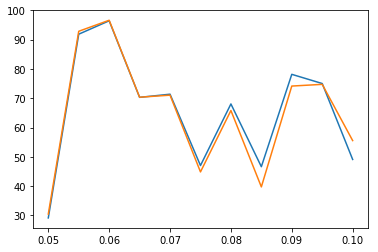

In [23]:
classifier = EllipticEnvelope
contaminations = np.linspace(0.05,0.10,11)
find_best_contamination(classifier, contaminations)

### One Class SVM

In [24]:
def find_best_gamma_svm(gamma_range):
    scores_train = []
    scores_test = []
    for g in gamma_range:
        print("Gamma = ", g)
        clf = svm.OneClassSVM(nu=nu,kernel='rbf',gamma=g)
        clf.fit(X_train)
        y_pred_train= -clf.predict(X_train)
        y_pred_test = -clf.predict(X_test)
        scores_train.append(profit(y_train,y_pred_train))
        print()
        scores_test.append(profit(y_test,y_pred_test))
        print()
        print()
    plt.title("Profit en fonction de gamma")
    plt.plot(gamma_range,scores_train,label="Score en apprentissage")
    plt.plot(gamma_range,scores_test,label="Score en test")
    plt.legend()
    plt.savefig('Profit_SVM_2.png')
    plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    stratify=target, 
                                                    test_size=0.2,
                                                    random_state=42)
scaler =  preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
gamma_range = np.linspace(10**-1, 5*10**-1, 5)

Gamma =  0.1
True Positive Rate:  0.4873096446700508
Number of False Positive:  5472
False Positive Rate:  0.024057928960523365


True Positive Rate:  0.7346938775510204
Number of False Positive:  2659
False Positive Rate:  0.0467606921778278



Gamma =  0.2
True Positive Rate:  0.4289340101522843
Number of False Positive:  18356
False Positive Rate:  0.08070309649111237


True Positive Rate:  0.8571428571428571
Number of False Positive:  7502
False Positive Rate:  0.13192881260551492



Gamma =  0.30000000000000004
True Positive Rate:  0.46446700507614214
Number of False Positive:  25760
False Positive Rate:  0.11325516265041702


True Positive Rate:  0.8877551020408163
Number of False Positive:  13012
False Positive Rate:  0.22882667416994934



Gamma =  0.4
True Positive Rate:  0.4035532994923858
Number of False Positive:  39141
False Positive Rate:  0.17208541619953308


True Positive Rate:  0.8571428571428571
Number of False Positive:  18292
False Positive Rate:  0.321679797411367

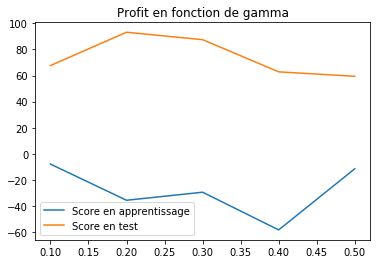

In [27]:
find_best_gamma_svm(gamma_range)

### Autoencoder 

In [31]:
def find_best_threshold_autoencoder(dim, thresholds):
    mean_score_train = np.zeros((len(dim),len(thresholds)))
    mean_score_test = np.zeros((len(dim),len(thresholds)))
    score_max = -np.inf
    dim_opti = 0
    for idx_dim,d in enumerate(dim):
        encoding_dim = int(d*data_ae.shape[1])
        input = Input(shape=(data_ae.shape[1],)) 
        encoded_1 = Dense(encoding_dim, activation='relu')(input)
        decoded_2 = Dense(data_ae.shape[1], activation='sigmoid')(encoded_1)
        autoencoder = Model(inputs=input, outputs=decoded_2)
        encoder = Model(inputs=input, outputs=encoded_1)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        score_train = 0
        score_test = 0
        for train_index, test_index in skf.split(data_ae, target):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index], target[test_index]
            print("Fit")
            autoencoder.fit(X_train, X_train,epochs=100,batch_size=X_train.shape[1],shuffle=True,verbose=1) 
            print("Predict")
            decoded_test = autoencoder.predict(X_test)
            decoded_train = autoencoder.predict(X_train)
            dist_train = np.zeros(X_train.shape[0]).reshape(-1,1)
            dist_test = np.zeros(X_test.shape[0]).reshape(-1,1)
            for i, x in enumerate(X_test):
                dist_test[i][0] = np.linalg.norm(x-decoded_test[i], ord = np.inf)
            for i, x in enumerate(X_train):
                dist_train[i][0] = np.linalg.norm(x-decoded_train[i], ord = np.inf)
            dist_train 
            for idx_t, t in enumerate(thresholds):
                y_pred_train = np.where(dist_train >=t,1,-1)
                y_pred_test = np.where(dist_test >=t,1,-1)
                mean_score_test[idx_dim][idx_t] += profit(y_test,y_pred_test,False)
                mean_score_train[idx_dim][idx_t] += profit(y_train,y_pred_train,False)   
            print("OK")
            print()
        print()
        print()
        print()
        mean_score_test[idx_dim,:] = mean_score_test[idx_dim,:]/5
        mean_score_train[idx_dim,:] = mean_score_train[idx_dim,:]/5

In [32]:
data_ae = normalized_data(data,"minmaxscaler")
dim = np.linspace(0.7,0.9,5)
thresholds = np.linspace(0.03,0.5,20)

In [33]:
find_best_threshold_autoencoder(dim, thresholds)

Fit
Epoch 1/100
227845/227845 [==============================] - 9s 39us/step - loss: -4.3914
Epoch 2/100
227845/227845 [==============================] - 9s 38us/step - loss: -5.3667
Epoch 3/100
227845/227845 [==============================] - 9s 39us/step - loss: -5.4580
Epoch 4/100
227845/227845 [==============================] - 9s 38us/step - loss: -5.4982
Epoch 5/100
227845/227845 [==============================] - 10s 43us/step - loss: -5.5229
Epoch 6/100
227845/227845 [==============================] - 10s 45us/step - loss: -5.5377
Epoch 7/100
227845/227845 [==============================] - 10s 43us/step - loss: -5.5475
Epoch 8/100
227845/227845 [==============================] - 11s 47us/step - loss: -5.5552
Epoch 9/100
227845/227845 [==============================] - 11s 50us/step - loss: -5.5629
Epoch 10/100
227845/227845 [==============================] - 11s 48us/step - loss: -5.5686
Epoch 11/100
227845/227845 [==============================] - 11s 47us/step - loss: -5.57

227845/227845 [==============================] - 10s 46us/step - loss: -5.6366
Epoch 91/100
227845/227845 [==============================] - 11s 48us/step - loss: -5.6365
Epoch 92/100
227845/227845 [==============================] - 10s 44us/step - loss: -5.6366
Epoch 93/100
227845/227845 [==============================] - 10s 44us/step - loss: -5.6367
Epoch 94/100
227845/227845 [==============================] - 9s 41us/step - loss: -5.6365
Epoch 95/100
227845/227845 [==============================] - 10s 45us/step - loss: -5.6370
Epoch 96/100
227845/227845 [==============================] - 11s 47us/step - loss: -5.6374
Epoch 97/100
227845/227845 [==============================] - 10s 43us/step - loss: -5.6376
Epoch 98/100
227845/227845 [==============================] - 11s 48us/step - loss: -5.6375
Epoch 99/100
227845/227845 [==============================] - 11s 48us/step - loss: -5.6373
Epoch 100/100
227845/227845 [==============================] - 10s 42us/step - loss: -5.6376
P

MemoryError: 

In [ ]:
dist_test = np.arange(7).reshape(-1,1)
dist_test = normalized_data(dist_test,"minmaxscaler")
print(dist_test)

In [ ]:
dist_test[2]